# Multi Layer Perceptron As A Function Approximator

We will utilize a multi layer perceptron (MLP) as a function approximator. 

We are given a set of data in 2D that is not linearly separable. We will transform the data into a 2D feature space using an MLP with one hidden-layer of 3 nodes. 

<img src="images/mlp.png" alt="alt text" width="300"/>

The data is first embedded into the 3D space by applying a linear transformation followed by a non-linear activation function, and then it is mapped back to 2D by applying a linear transformation. We hope that data becomes linearly separable in the 2D feature space.

## Create Data

We have a set of data residing on two concentric circles. Data on each circle belongs to separate classes. We formulate a binary classification problem and train the given MLP to perform the task.

In [1]:
import numpy as np

# for reproducibility
np.random.seed(23)

# create data of circles and plot
N=101 # num data points in each circle
t=np.linspace(0,1,N)
r_list = [0.3,1.0] # radius list for circles


x_list = []
y_list = []
for i,r in enumerate(r_list):
    x = r*np.sin(2*np.pi*t) + np.random.randn(N)*0#0.03
    y = r*np.cos(2*np.pi*t) + np.random.randn(N)*0#0.03
    
    x_list.append(x)
    y_list.append(y)

# consolidate data
x_arr = np.concatenate(x_list)
y_arr = np.concatenate(y_list)
data_arr = np.stack([x_arr,y_arr],axis=0)
label_arr = np.concatenate([np.zeros(N,dtype=np.uint8),np.ones(N,dtype=np.uint8)])

# initiate all with the color of 1st quadrant
marker_color_arr = np.ones(2*N,dtype=np.uint8)

# 2nd quadrant
indices = (data_arr[0] < 0) & (data_arr[1] >= 0)
marker_color_arr[indices] = 2

# 3rd quadrant
indices = (data_arr[0] < 0) & (data_arr[1] < 0)
marker_color_arr[indices] = 3

# 4th quadrant
indices = (data_arr[0] >= 0) & (data_arr[1] < 0)
marker_color_arr[indices] = 4

### Helper function to plot data

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

cmap_list = ['Reds','Blues','autumn','winter']

def plot_data(ax,data_arr,label_arr,marker_color_arr):
    unique_label_arr = np.unique(label_arr)
    num_labels = len(unique_label_arr)
    
    ax.set_aspect('equal')
    
    for i in range(num_labels):
        temp_cmap = matplotlib.cm.get_cmap(cmap_list[i])
        
        temp_indices = label_arr==unique_label_arr[i]
        temp_data_arr = data_arr[:,temp_indices]
        temp_label_arr = label_arr[temp_indices]
        temp_marker_color_arr = marker_color_arr[temp_indices]

        ax.scatter(temp_data_arr[0],temp_data_arr[1],s=5,c=temp_marker_color_arr,cmap=temp_cmap,vmin=0)
        
    ax.set_axisbelow(True)
    ax.grid(color='gray', linestyle='dashed')
        
        

### Plot the data

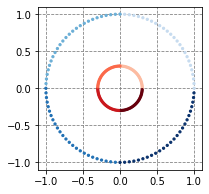

In [3]:
# plot the data
fig,ax = plt.subplots(figsize=(3,3))
plot_data(ax,data_arr,label_arr,marker_color_arr)


## Construct and Train an MLP in PyTorch

### Create a dataset and dataloader

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.utils.data

In [6]:
# convert numpy arrays to tensors
samples = torch.as_tensor(data_arr.transpose(), dtype=torch.float32)
labels = torch.as_tensor(label_arr, dtype=torch.long)

dataset_train = torch.utils.data.TensorDataset(samples,labels)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=0)

### Constructing the model

In [7]:
class SimpleNN(nn.Module):
    def __init__(self, num_features=1, nonlinearity='relu', initialization='default'):
        super().__init__()
        
        # for reproducibility
        torch.manual_seed(23)
        
        self.nonlinearity = nonlinearity
        
        self.fc1 = nn.Linear(2, num_features, bias=True)
        self.fc2 = nn.Linear(num_features, 2, bias=True)
        
        if initialization == 'normal':
            torch.nn.init.normal_(self.fc1.weight, mean=0.0, std=1.0)
            torch.nn.init.normal_(self.fc1.bias, mean=0.0, std=1.0)
            torch.nn.init.normal_(self.fc2.weight, mean=0.0, std=1.0)
            torch.nn.init.normal_(self.fc2.bias, mean=0.0, std=1.0)
        elif initialization == 'xavier':
            torch.nn.init.xavier_uniform_(self.fc1.weight)
            torch.nn.init.xavier_uniform_(self.fc2.weight)
        elif initialization == 'zeros':
            torch.nn.init.zeros_(self.fc1.weight)
            torch.nn.init.zeros_(self.fc1.bias)
            torch.nn.init.zeros_(self.fc2.weight)
            torch.nn.init.zeros_(self.fc2.bias)
        
    def forward(self, x):
        s1 = self.fc1(x)
        
        if self.nonlinearity == 'relu':
            z1 = F.relu(s1)
        elif self.nonlinearity == 'sigmoid':    
            z1 = torch.sigmoid(s1)
        elif self.nonlinearity == 'tanh': 
            z1 = torch.tanh(s1)
        else:
            z1 = s1
                 
        y = self.fc2(z1)

        
        return s1,z1,y

### Train the model

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Optimizer Performance Analysis

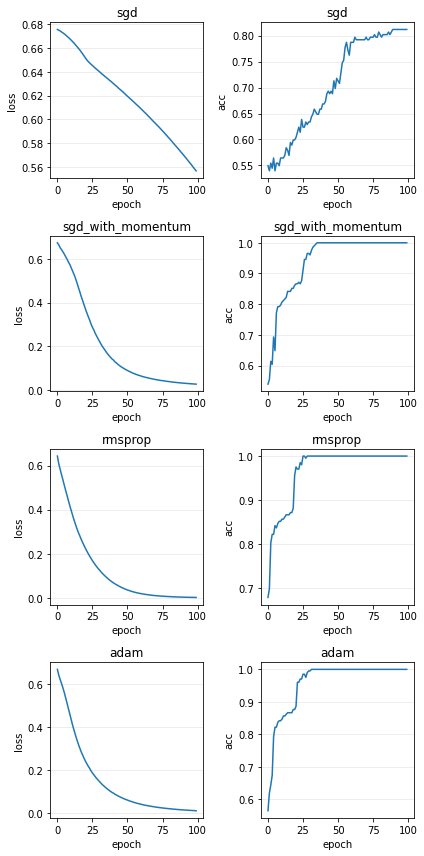

In [9]:
# check model performance with different optimizers
optimizer_list = ['sgd','sgd_with_momentum','rmsprop','adam']

# book-keeping for plots
loss_dict = dict()
acc_dict = dict()

for temp_opt in optimizer_list:
    # get the model using our helper function
    model = SimpleNN(num_features=3, initialization='default')

    # move model to the right device
    model.to(device)

    # define criterion/loss function
    criterion = nn.CrossEntropyLoss()

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    
    if temp_opt == 'sgd':
        optimizer = torch.optim.SGD(params, lr=3e-3)
    elif temp_opt == 'sgd_with_momentum':
        optimizer = torch.optim.SGD(params, lr=3e-3, momentum=0.9)
    elif temp_opt == 'rmsprop':
        optimizer = torch.optim.RMSprop(params, lr=3e-3)
    elif temp_opt == 'adam':
        optimizer = torch.optim.Adam(params, lr=3e-3)

    num_epochs = 100
    train_loss_list = []
    train_acc_list = []
    for epoch in range(num_epochs):

        # set the model into training mode
        model.train()

        num_predictions = 0
        running_loss = 0.0
        running_num_correct_preds = 0

        for i, (temp_sample, temp_label) in enumerate(dataloader_train):

            # push the mini-batch of data into device
            # if you have a GPU, the data will be pushed into GPU
            temp_sample, temp_label = temp_sample.to(device), temp_label.to(device)


            # 1. feed-forward pass
            _,_,temp_output = model(temp_sample)

            # 2. calculate the loss
            loss = criterion(temp_output, temp_label)

            # 3. clear the gradients
            optimizer.zero_grad()

            # 4. backward pass (back-propagation)
            # to compute gradients of parameters
            loss.backward()

            # 5. update the parameters
            optimizer.step()


            # get the predicted labels
            _, predicted_label = torch.max(temp_output, 1)

            # book-keeping
            num_correct_preds = (predicted_label == temp_label).sum().item()

            num_samples = temp_label.size(0)
            num_predictions += num_samples

            running_loss += loss.item() * num_samples
            running_num_correct_preds += num_correct_preds

        train_loss = running_loss / num_predictions
        train_acc = running_num_correct_preds / num_predictions
    #     print(train_loss)
    #     print(train_acc)


        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
    
    loss_dict[temp_opt] = train_loss_list
    acc_dict[temp_opt] = train_acc_list

# plot the loss and accuracy throughout training
fig,ax = plt.subplots(len(optimizer_list),2,figsize=(6,3*len(optimizer_list)))

for i,temp_opt in enumerate(optimizer_list):
    ax[i,0].plot(np.arange(num_epochs),loss_dict[temp_opt])
    ax[i,0].set_title(temp_opt)
    ax[i,0].set_xlabel('epoch')
    ax[i,0].set_ylabel('loss')
    ax[i,0].set_axisbelow(True)
    ax[i,0].yaxis.grid(True,which='major',linestyle='-',color='lightgrey',alpha=0.5)

    ax[i,1].plot(np.arange(num_epochs),acc_dict[temp_opt])
    ax[i,1].set_title(temp_opt)
    ax[i,1].set_xlabel('epoch')
    ax[i,1].set_ylabel('acc')
    ax[i,1].set_axisbelow(True)
    ax[i,1].yaxis.grid(True,which='major',linestyle='-',color='lightgrey',alpha=0.5)

fig.tight_layout()

### Weight Initialization Performance Analysis

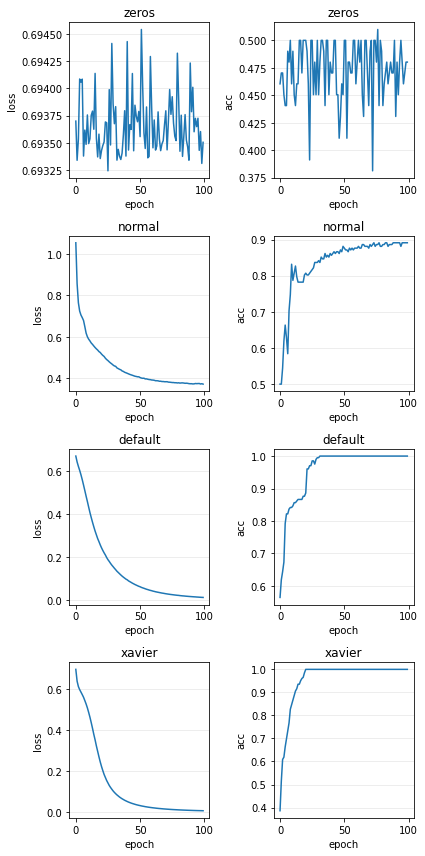

In [10]:
# check model performance with different weight initializations
initialization_list = ['zeros','normal','default','xavier']

# book-keeping for plots
loss_dict = dict()
acc_dict = dict()

for temp_init in initialization_list:
    
    # get the model using our helper function
    model = SimpleNN(num_features=3, initialization=temp_init)

    # move model to the right device
    model.to(device)

    # define criterion/loss function
    criterion = nn.CrossEntropyLoss()

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=3e-3)

    num_epochs = 100
    train_loss_list = []
    train_acc_list = []
    for epoch in range(num_epochs):

        # set the model into training mode
        model.train()

        num_predictions = 0
        running_loss = 0.0
        running_num_correct_preds = 0

        for i, (temp_sample, temp_label) in enumerate(dataloader_train):

            # push the mini-batch of data into device
            # if you have a GPU, the data will be pushed into GPU
            temp_sample, temp_label = temp_sample.to(device), temp_label.to(device)


            # 1. feed-forward pass
            _,_,temp_output = model(temp_sample)

            # 2. calculate the loss
            loss = criterion(temp_output, temp_label)

            # 3. clear the gradients
            optimizer.zero_grad()

            # 4. backward pass (back-propagation)
            # to compute gradients of parameters
            loss.backward()

            # 5. update the parameters
            optimizer.step()


            # get the predicted labels
            _, predicted_label = torch.max(temp_output, 1)

            # book-keeping
            num_correct_preds = (predicted_label == temp_label).sum().item()

            num_samples = temp_label.size(0)
            num_predictions += num_samples

            running_loss += loss.item() * num_samples
            running_num_correct_preds += num_correct_preds

        train_loss = running_loss / num_predictions
        train_acc = running_num_correct_preds / num_predictions
    #     print(train_loss)
    #     print(train_acc)


        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
    
    loss_dict[temp_init] = train_loss_list
    acc_dict[temp_init] = train_acc_list

# plot the loss and accuracy throughout training
fig,ax = plt.subplots(len(initialization_list),2,figsize=(6,3*len(initialization_list)))

for i,temp_init in enumerate(initialization_list):
    ax[i,0].plot(np.arange(num_epochs),loss_dict[temp_init])
    ax[i,0].set_title(temp_init)
    ax[i,0].set_xlabel('epoch')
    ax[i,0].set_ylabel('loss')
    ax[i,0].set_axisbelow(True)
    ax[i,0].yaxis.grid(True,which='major',linestyle='-',color='lightgrey',alpha=0.5)

    ax[i,1].plot(np.arange(num_epochs),acc_dict[temp_init])
    ax[i,1].set_title(temp_init)
    ax[i,1].set_xlabel('epoch')
    ax[i,1].set_ylabel('acc')
    ax[i,1].set_axisbelow(True)
    ax[i,1].yaxis.grid(True,which='major',linestyle='-',color='lightgrey',alpha=0.5)

fig.tight_layout()